# Lyric DEA #

## Imports, Inits, and Method definitions ##

In [64]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import importlib

import mcnulty_methods
import word_utils
importlib.reload(mcnulty_methods);
importlib.reload(word_utils);
from mcnulty_methods import get_formatted_feature_df, get_lyrics_for_tracks
from word_utils import get_word_counts, generate_word_charts

In [54]:
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13

In [55]:
def get_artist_term_counts():
    term_counts = pd.read_csv('top_artist_terms.csv', index_col='artist_id', names=['artist_id','term', 'term_count'])
    term_counts = term_counts[~(term_counts['term'] == 'term')]
    del term_counts['term_count']
    return term_counts


def get_term_counts():
    return pd.read_csv('term_counts.csv', names=['term', 'count'])

## Fetch Tracks for Particular Genres

In [56]:
conn = create_engine('postgresql://@localhost:5432/mcnulty_songs').raw_connection()
cursor = conn.cursor()

In [57]:
features = get_formatted_feature_df(conn)

In [58]:
features.shape

(66730, 11)

In [59]:
features.sample(5)

,title,artist_id,artist_name,track_id,term,duration,music_key,loudness,mode,music_tempo,time_signature
49599,Amor Ciego - Original,ARPCEWC11F4C83EEA7,Eddie Palmieri and Friends,TRSFYFW128F930D6CE,pop,237.73995,0,-16.793,0,146.878,1
18943,Make me feel,AR0JBWB1187B98A662,Mariana,TRFZRTJ12903CC31CF,pop,207.90812,7,-7.075,1,125.011,4
14311,Back Wordz,ARZH4561187B9AE9FB,Bekay,TRRTPVJ128F427AD6C,hip hop,204.27710,0,-10.054,1,112.002,4
12888,Game For You,AR6OL631187FB49241,Colby O'Donis,TRCYJKK128F92DF5E5,pop,204.32934,11,-6.664,1,104.996,4
4744,Pretty Girl,ARO80D41187B9B8D8F,Jon B,TRWOFYM128F4263BBB,pop,257.61914,0,-9.420,1,92.981,4


## Fetch Lyrics from Tracks ##

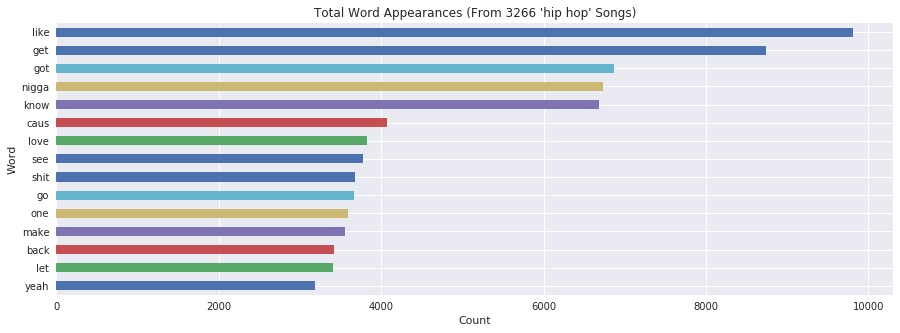

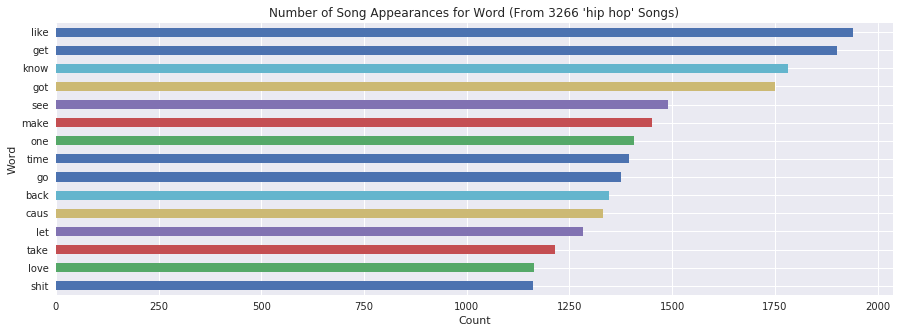

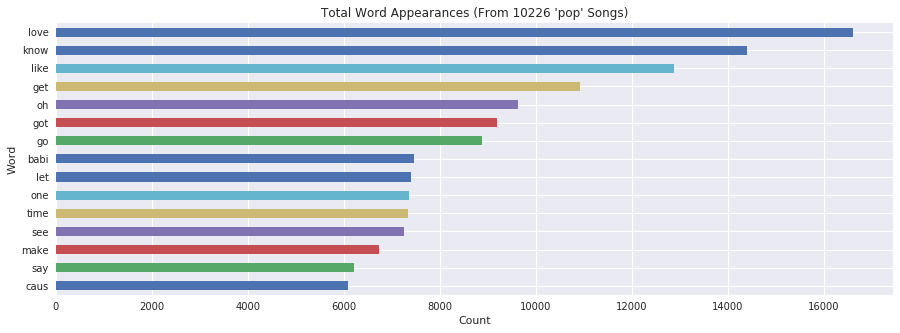

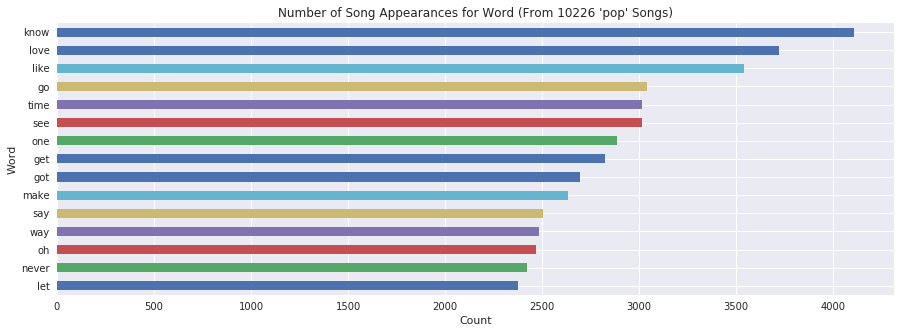

In [65]:
genre_labels = ['hip hop', 'pop']
unique_words = set()

all_lyrics = None
hiphop_lyrics = None
pop_lyrics = None

for genre_label in genre_labels:
    genre_df = features[(features['term'] == genre_label)]

    genre_ids = genre_df['track_id']
    
    genre_lyrics = get_lyrics_for_tracks(conn, genre_ids)

    
    if genre_label == 'pop':
        pop_lyrics = genre_lyrics
    elif genre_label == 'hip hop':
        hiphop_lyrics = genre_lyrics
        
    if all_lyrics is None:
        all_lyrics = genre_lyrics
    else:
        all_lyrics = pd.concat([all_lyrics, genre_lyrics])
    
    generate_word_charts(genre_lyrics, genre_label)


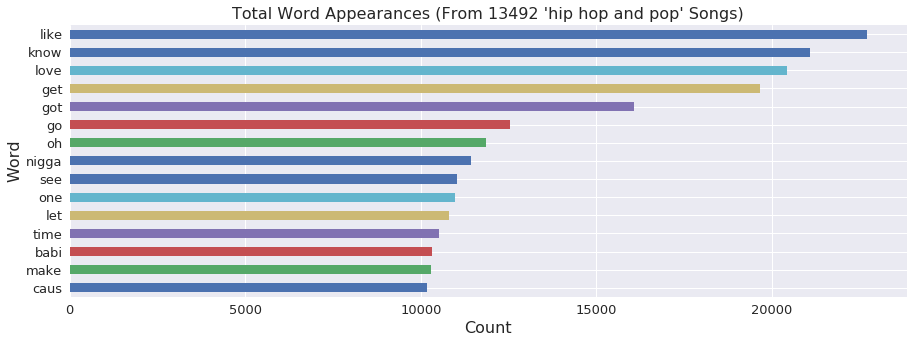

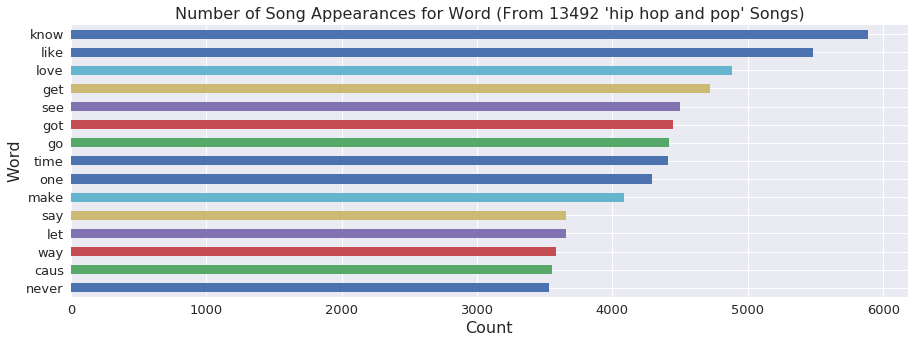

In [40]:
generate_word_charts(all_lyrics, 'hip hop and pop')

In [41]:
total_count_of_words = all_lyrics.groupby('word')['count'].sum().reset_index()

total_count_of_words.sort_values('count', ascending=False, inplace=True)

total_count_of_words.head(10)

,word,count
2170,like,22699
2069,know,21079
2237,love,20439
1593,get,19670
1647,got,16060
1631,go,12534
2609,oh,11859
2543,nigga,11441
3291,see,11026
2632,one,10963


In [15]:
track_word_counts = all_lyrics.groupby('track_id')['count'].sum()

#track_word_counts.sort_values('count', ascending=False, inplace=True)

## Hip Hop: Analyze per track word counts ##

In [16]:
track_word_counts = hiphop_lyrics.groupby('track_id')['count'].sum().reset_index()

track_word_counts.sort_values('count', ascending=False, inplace=True)

track_word_counts['count'].describe()

count    3266.000000
mean      178.008879
std       110.165940
min         1.000000
25%        89.000000
50%       173.000000
75%       248.000000
max      2133.000000
Name: count, dtype: float64

## Pop: Analyze per track word counts ##

In [17]:
track_word_counts = pop_lyrics.groupby('track_id')['count'].sum().reset_index()

track_word_counts.sort_values('count', ascending=False, inplace=True)

track_word_counts['count'].describe()

count    10226.000000
mean       104.277039
std         79.867972
min          1.000000
25%         52.000000
50%         83.000000
75%        130.000000
max       1350.000000
Name: count, dtype: float64

May want to consider dropping tracks with very few words

In [18]:
features.set_index('track_id', inplace=True)

## Word Analysis and Reshaping for Modeling ##

In [19]:
word_song_appearance, total_word_appearance = get_word_counts(all_lyrics)

print('Total Unique Words: {}'.format(word_song_appearance.shape[0]))
print('-------------------')
print(word_song_appearance.describe())
print('-------------------')


Total Unique Words: 4351
-------------------
             count
count  4351.000000
mean    199.842105
std     414.345192
min       1.000000
25%      40.000000
50%      76.000000
75%     175.000000
max    5888.000000
-------------------


## Feature Selection ##

Starting with the top x words found per song in the dataset, we'll add features and record the results from our classification models

In [20]:
def plot_ROC_compute_AUC(model, model_name, X,y):
    X_val, X_val_test, y_val, y_val_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    lr_3x.fit(X_val, y_val)
    y_prob = lr_3x.predict_proba(X_val_test)[:,1]
    auc = roc_auc_score(y_val_test, y_prob)
    
    return auc
    #TODO save these
    fpr, tpr, _ = roc_curve(y_val_test, y_prob)
    auc = roc_auc_score(y_val_test, y_prob)

    plt.plot(fpr, tpr)

    x = np.linspace(0,1, 100000)
    plt.plot(x, x, linestyle='--')

    plt.title('ROC Curve (Pop or Hip Hop)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(['Logistic Regression'])
    return auc

In [21]:
def create_test_result_df(rows):
    test_results = pd.DataFrame(rows, columns=['num_words','model','accuracy','precision','recall','f1','auc'])
    test_results['accuracy'] = test_results['accuracy'].astype(np.float64)
    test_results['precision'] = test_results['precision'].astype(np.float64)
    test_results['recall'] = test_results['recall'].astype(np.float64)
    test_results['f1'] = test_results['f1'].astype(np.float64)
    test_results['auc'] = test_results['auc'].astype(np.float64)
    return test_results

In [25]:
del all_lyrics['is_test']

In [27]:
all_lyrics.sample(5)

,word,count
track_id,,
TREQUFU128E0798B10,let,2
TRDPEUG128F1479BC7,perfect,1
TRVVOUX128F1456D85,green,2
TRJDJDD128F42598DD,mission,1
TRLVUNF128F931A650,rise,1


In [ ]:
#word_subset = word_song_appearance[word_song_appearance['count'] >= 500]
cv_df_count = 0

log_model = LogisticRegression()
lr_2x = LogisticRegression(class_weight={1 : 2, 0 : 1})
lr_3x = LogisticRegression(class_weight={1 : 3, 0 : 1})
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1})

word_chunk_size = 10
word_upper_bound = 3010
# let's stop at 3000 words
test_results = create_test_result_df(None)

for word_sample_size in range(10, word_upper_bound, word_chunk_size):
    test_df_index = 0
    word_subset = word_song_appearance.iloc[:word_sample_size]

    remaining_lyrics = pd.merge(all_lyrics.reset_index(), word_subset[['word']], how='right', on='word')

    remaining_lyrics.set_index('track_id', inplace=True)
    del remaining_lyrics['is_test']
    tid_lyrics = remaining_lyrics.pivot(columns='word', values='count')

    music_features = ['duration','music_key','loudness', 'mode', 'music_tempo', 'time_signature']
    term_only = features[['term']].reset_index().set_index('track_id')

    # complete set,= tid_index -> genre -> word_a -> .... -> word_z
    complete_set = pd.merge(term_only, tid_lyrics, left_index=True, right_index=True, how='right')
    complete_set.fillna(0, inplace=True)


    test_size = 0.2
    random_state = 10
    y_text = np.asarray(complete_set.iloc[:,0])
    y = np.array([1 if val=='hip hop' else 0 for val in y_text])
    X = np.asarray(complete_set.iloc[:,1:])

    X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    models = [log_model, lr_2x, lr_3x, lr_4x]
    model_names = ['log', 'log_2:1', 'log_3:1', 'log_4:1']
    cv_rows = []
    for idx, model in enumerate(models):
        accuracy = np.mean(cross_val_score(model, X_val, y_val, cv=5, n_jobs=-1, scoring='accuracy'))
        precision = np.mean(cross_val_score(model, X_val, y_val, cv=5, n_jobs=-1, scoring='precision'))
        recall = np.mean(cross_val_score(model, X_val, y_val, cv=5, n_jobs=-1, scoring='recall'))
        f1 = np.mean(cross_val_score(model, X_val, y_val, cv=5, n_jobs=-1, scoring='f1'))
        model_name = model_names[idx]
        auc = plot_ROC_compute_AUC(model, model_name, X_val, y_val)
        
        cv_row = [word_sample_size, model_name, accuracy, precision, recall, f1, auc]
        cv_rows.append(cv_row)
    
    new_df = create_test_result_df(cv_rows)
    
    test_results = test_results.append(new_df, ignore_index=True)
    #test_results.to_csv('cv_files/feature_cv_results.csv')
        
    

**2:1(lr_3x) Hip Hop to Pop weighting seems to be the winner**

In [ ]:

    
plot_ROC_compute_AUC(X_val, y_val)

In [ ]:
models = [GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]
scores = []
model_name = []
for idx, model in enumerate(models):
    accuracy = cross_val_score(model, X_val, y_val, cv=5, n_jobs=-1, scoring='accuracy')
    precision = cross_val_score(model, X_val, y_val, cv=5, n_jobs=-1, scoring='precision')
    recall = cross_val_score(model, X_val, y_val, cv=5, n_jobs=-1, scoring='recall')
    f1 = cross_val_score(model, X_val, y_val, cv=5, n_jobs=-1, scoring='f1')

    print('TRAINING SCORES: {}'.format(idx))
    print('----------------')
    print('Accuracy: {}'.format(np.mean(accuracy)))
    print('Precision: {}'.format(np.mean(precision)))
    print('Recall: {}'.format(np.mean(recall)))
    print('F1: {}'.format(np.mean(f1)))
    print('----------------')
    
    

In [ ]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

gbm = xgb.XGBClassifier( 
                        n_estimators=10000,
                        max_depth=7,
                        objective='binary:logistic', #new objective
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=12,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

In [ ]:
f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 